# Task 4 Ptbdb Data CNN Transfer Learning with augmentations

## Loading modules
Note we load models, data and plotting function from models.ipynb and helper_functions.ipynb

In [1]:
import itertools

In [2]:
import io
import numpy as np
import os
import pandas as pd
import pathlib
import shutil
import random
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_similarity as tfsim
from inspect import signature
from keras import losses
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from matplotlib import pyplot as plt
from pathlib import Path
from scipy import stats
from sklearn import metrics
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    f1_score,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split
from tensorflow import keras

In [3]:
%load_ext tensorboard
# For evaluation

## Load needed functions

In [4]:
def get_data(data, data_path, zscore=True):
    if data == "mitbih":
        df_train = pd.read_csv(data_path+"/mitbih_train.csv", header=None)
        df_train = df_train.sample(frac=1)
        df_test = pd.read_csv(data_path+"/mitbih_test.csv", header=None)

        Y = np.array(df_train[187].values).astype(np.int8)
        X = np.array(df_train[list(range(187))].values)[..., np.newaxis]

        Y_test = np.array(df_test[187].values).astype(np.int8)
        X_test = np.array(df_test[list(range(187))].values)[..., np.newaxis]

    elif data == "ptbdb":
        df_1 = pd.read_csv(data_path+"/ptbdb_normal.csv", header=None)
        df_2 = pd.read_csv(data_path+"/ptbdb_abnormal.csv", header=None)
        df = pd.concat([df_1, df_2])

        df_train, df_test = train_test_split(
            df, test_size=0.2, random_state=1337, stratify=df[187])

        Y = np.array(df_train[187].values).astype(np.int8)
        X = np.array(df_train[list(range(187))].values)[..., np.newaxis]

        Y_test = np.array(df_test[187].values).astype(np.int8)
        X_test = np.array(df_test[list(range(187))].values)[..., np.newaxis]

    if zscore:
        X = stats.zscore(X, axis=1)
        X_test = stats.zscore(X_test, axis=1)

    return X, X_test, Y, Y_test


def log_confusion_matrix(epoch, logs):
  # Use the model to predict the values from the validation dataset.
    test_pred = model.predict(X_test)
    test_pred = (test_pred > 0.5).astype(np.int8)
    cm = metrics.confusion_matrix(Y_test, test_pred)
    normalize = False
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    figure = plt.figure(figsize=(9, 6))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(model_name+" Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

    buf = io.BytesIO()
    plt.savefig(buf, format='png')

    plt.close(figure)
    buf.seek(0)
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    image = tf.expand_dims(image, 0)

    # Log the confusion matrix as an image summary.
    file_writer = tf.summary.create_file_writer(tensorboard_path)
    with file_writer.as_default():
        tf.summary.image("Confusion Matrix", image, step=epoch)


def log_auroc(epoch, logs):
  # Use the model to predict the values from the validation dataset.
    pred_test = model.predict(X_test)
    pred_test = (pred_test > 0.5).astype(np.int8)

    fpr, tpr, thresholds = roc_curve(Y_test, pred_test)
    figure = plt.figure(figsize=(9, 6))
    plt.plot(
        fpr,
        tpr,
        color="b",
        label=r"Model (AUC = %0.3f)" % (roc_auc_score(Y_test, pred_test)),
        lw=2,
        alpha=0.8,
    )
    plt.plot(
        [0, 1],
        [0, 1],
        linestyle="--",
        lw=2,
        color="r",
        label="Luck (AUC = 0.5)",
        alpha=0.8,
    )
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(model_name+"-AUROC")
    plt.legend(loc="lower right")

    buf = io.BytesIO()
    plt.savefig(buf, format='png')

    plt.close(figure)
    buf.seek(0)
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    image = tf.expand_dims(image, 0)

    # Log the auroc as an image summary.
    file_writer = tf.summary.create_file_writer(tensorboard_path)
    with file_writer.as_default():
        tf.summary.image("AUROC", image, step=epoch)


def log_auprc(epoch, logs):
  # Use the model to predict the values from the validation dataset.
    pred_test = model.predict(X_test)
    pred_test = (pred_test > 0.5).astype(np.int8)

    average_precision = average_precision_score(Y_test, pred_test)
    precision, recall, _ = precision_recall_curve(Y_test, pred_test)
    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = (
        {"step": "post"} if "step" in signature(
            plt.fill_between).parameters else {}
    )

    figure = plt.figure(figsize=(9, 6))
    plt.step(recall, precision, color="b", alpha=0.2, where="post")
    plt.fill_between(recall, precision, alpha=0.2, color="b", **step_kwargs)

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(model_name+"-AUPRC: AP={0:0.3f}".format(average_precision))

    buf = io.BytesIO()
    plt.savefig(buf, format='png')

    plt.close(figure)
    buf.seek(0)
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    image = tf.expand_dims(image, 0)

    # Log the auroc as an image summary.
    file_writer = tf.summary.create_file_writer(tensorboard_path)
    with file_writer.as_default():
        tf.summary.image("AUPRC", image, step=epoch)


def plot_roc(y_actual, y_pred):
    """
    Function to plot AUC-ROC curve
    """
    fpr, tpr, thresholds = roc_curve(y_actual, y_pred)
    plt.figure(figsize=(9, 6))
    plt.plot(
        fpr,
        tpr,
        color="b",
        label=r"Model (AUC = %0.2f)" % (roc_auc_score(y_actual, y_pred)),
        lw=2,
        alpha=0.8,
    )
    plt.plot(
        [0, 1],
        [0, 1],
        linestyle="--",
        lw=2,
        color="r",
        label="Luck (AUC = 0.5)",
        alpha=0.8,
    )
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend(loc="lower right")
    plt.show()


def plot_precisionrecall(y_actual, y_pred):
    """
    Function to plot AUC-ROC curve
    """
    average_precision = average_precision_score(y_actual, y_pred)
    precision, recall, _ = precision_recall_curve(y_actual, y_pred)
    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = (
        {"step": "post"} if "step" in signature(
            plt.fill_between).parameters else {}
    )

    plt.figure(figsize=(9, 6))
    plt.step(recall, precision, color="b", alpha=0.2, where="post")
    plt.fill_between(recall, precision, alpha=0.2, color="b", **step_kwargs)

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title("Precision-Recall curve: AP={0:0.2f}".format(average_precision))


def plot_confusion_matrix(
    y_true,
    y_pred,
    classes,
    normalize=False,
    title="Confusion matrix",
    cmap=plt.cm.Blues,
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = metrics.confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    print(cm)
    plt.figure(figsize=(9, 6))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")


def get_transfer_model(model):
    model.trainable = False
    model_input = model.inputs
    model_output = model.layers[-4].output

    X = keras.layers.Dense(32, activation='relu')(model_output)
    X = keras.layers.Dense(32, activation='relu')(X)
    out = keras.layers.Dense(1, activation='sigmoid')(X)

    transfer_model = keras.Model(inputs=model_input, outputs=out)
    return transfer_model


def plot_model_results(model, history, model_path, data, model_name, X_test, Y_test):
    model.load_weights(model_path)
    if model_name == "ResNet":
        X_test = np.expand_dims(X_test, -1)
        Y_test = np.expand_dims(Y_test, -1)
        model.evaluate(X_test, Y_test)
    if data == "mitbih":
        mitbih_dict = {'N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4}
        pred_test = model.predict(X_test)
        pred_test = np.argmax(pred_test, axis=-1)

        pd.DataFrame(history.history).plot(figsize=(8, 5))

        f1 = f1_score(Y_test, pred_test, average="macro")
        acc = accuracy_score(Y_test, pred_test)

        print("Test F1 score : {:.4f}".format(np.mean(f1)))
        print("Test ACC score : {:.4f}".format(np.mean(acc)))

        plot_confusion_matrix(
            Y_test,
            pred_test,
            [*mitbih_dict],
            normalize=True,
            title="Confusion matrix",
            cmap=plt.cm.Blues)
    elif data == "ptbdb":
        ptbdb_dict = {'Normal': 0, 'Abnormal': 1}
        pred_test = model.predict(X_test)
        pred_test = (pred_test > 0.5).astype(np.int8)
        f1 = f1_score(Y_test, pred_test, average="macro")
        acc = accuracy_score(Y_test, pred_test)
        print("Test F1 score : {:.4f}".format(np.mean(f1)))
        print("Test ACC score : {:.4f}".format(np.mean(acc)))
        plot_confusion_matrix(
            Y_test,
            pred_test,
            [*ptbdb_dict],
            normalize=False,
            title="Confusion matrix",
            cmap=plt.cm.Blues)
        plot_roc(Y_test, pred_test)
        plot_precisionrecall(Y_test, pred_test)
import warnings
warnings.filterwarnings('ignore')
def augment(x,y,*args):
    aug_types_list = ["jitter",
                      "scaling","rotation",
                      "permutation0","permutation1",
                      "time_warp","window_slice","window_warp"
                     ]
    x = tf.cast(x, tf.float32)
    x = x.numpy()
    augment_probability = 0.5
    augment_layers = 6
    if random.random() < augment_probability:
        how_many_augments = random.randint(1,augment_layers)
        aug_types_list = random.sample(aug_types_list,how_many_augments)
    else:
        aug_types_list=["NoAugments"]
        
    if "jitter" in aug_types_list:
        x = jitter(x)
    if "scaling" in aug_types_list:
        x = scaling(x)
    if "rotation" in aug_types_list:
        x = rotation(x)
    if "permutation0" in aug_types_list:
        x = permutation(x)
    if "permutation1" in aug_types_list:
        x = permutation(x, seg_mode="random")

    if "time_warp" in aug_types_list:
        x = time_warp(x)
    if "window_slice" in aug_types_list:
        x = window_slice(x)
    if "window_warp" in aug_types_list:
        x = window_warp(x)

    return x,y

def jitter(x, sigma=0.03):
    # https://arxiv.org/pdf/1706.00527.pdf
    return x + np.random.normal(loc=0., scale=sigma, size=x.shape)

def scaling(x, sigma=0.1):
    # https://arxiv.org/pdf/1706.00527.pdf
    factor = np.random.normal(loc=1., scale=sigma, size=(x.shape[0],x.shape[2]))
    return np.multiply(x, factor[:,np.newaxis,:])

def rotation(x):
    flip = np.random.choice([-1, 1], size=(x.shape[0],x.shape[2]))
    rotate_axis = np.arange(x.shape[2])
    np.random.shuffle(rotate_axis)    
    return flip[:,np.newaxis,:] * x[:,:,rotate_axis]

def permutation(x, max_segments=5, seg_mode="equal"):
    orig_steps = np.arange(x.shape[1])
    
    num_segs = np.random.randint(1, max_segments, size=(x.shape[0]))
    
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        if num_segs[i] > 1:
            if seg_mode == "random":
                split_points = np.random.choice(x.shape[1]-2, num_segs[i]-1, replace=False)
                split_points.sort()
                splits = np.split(orig_steps, split_points)
            else:
                splits = np.array_split(orig_steps, num_segs[i])
            warp = np.concatenate(np.random.permutation(splits)).ravel()
            ret[i] = pat[warp]
        else:
            ret[i] = pat
    return ret

def magnitude_warp(x, sigma=0.2, knot=4):
    from scipy.interpolate import CubicSpline
    orig_steps = np.arange(x.shape[1])
    
    random_warps = np.random.normal(loc=1.0, scale=sigma, size=(x.shape[0], knot+2, x.shape[2]))
    warp_steps = (np.ones((x.shape[2],1))*(np.linspace(0, x.shape[1]-1., num=knot+2))).T
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        warper = np.array([CubicSpline(warp_steps[:,dim], random_warps[i,:,dim])(orig_steps) for dim in range(x.shape[2])]).T
        ret[i] = pat * warper

    return ret

def time_warp(x, sigma=0.2, knot=4):
    from scipy.interpolate import CubicSpline
    orig_steps = np.arange(x.shape[1])
    
    random_warps = np.random.normal(loc=1.0, scale=sigma, size=(x.shape[0], knot+2, x.shape[2]))
    warp_steps = (np.ones((x.shape[2],1))*(np.linspace(0, x.shape[1]-1., num=knot+2))).T
    
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        for dim in range(x.shape[2]):
            time_warp = CubicSpline(warp_steps[:,dim], warp_steps[:,dim] * random_warps[i,:,dim])(orig_steps)
            scale = (x.shape[1]-1)/time_warp[-1]
            ret[i,:,dim] = np.interp(orig_steps, np.clip(scale*time_warp, 0, x.shape[1]-1), pat[:,dim]).T
    return ret

def window_slice(x, reduce_ratio=0.9):
    # https://halshs.archives-ouvertes.fr/halshs-01357973/document
    target_len = np.ceil(reduce_ratio*x.shape[1]).astype(int)
    if target_len >= x.shape[1]:
        return x
    starts = np.random.randint(low=0, high=x.shape[1]-target_len, size=(x.shape[0])).astype(int)
    ends = (target_len + starts).astype(int)
    
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        for dim in range(x.shape[2]):
            ret[i,:,dim] = np.interp(np.linspace(0, target_len, num=x.shape[1]), np.arange(target_len), pat[starts[i]:ends[i],dim]).T
    return ret

def window_warp(x, window_ratio=0.1, scales=[0.5, 2.]):
    # https://halshs.archives-ouvertes.fr/halshs-01357973/document
    warp_scales = np.random.choice(scales, x.shape[0])
    warp_size = np.ceil(window_ratio*x.shape[1]).astype(int)
    window_steps = np.arange(warp_size)
        
    window_starts = np.random.randint(low=1, high=x.shape[1]-warp_size-1, size=(x.shape[0])).astype(int)
    window_ends = (window_starts + warp_size).astype(int)
            
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        for dim in range(x.shape[2]):
            start_seg = pat[:window_starts[i],dim]
            window_seg = np.interp(np.linspace(0, warp_size-1, num=int(warp_size*warp_scales[i])), window_steps, pat[window_starts[i]:window_ends[i],dim])
            end_seg = pat[window_ends[i]:,dim]
            warped = np.concatenate((start_seg, window_seg, end_seg))                
            ret[i,:,dim] = np.interp(np.arange(x.shape[1]), np.linspace(0, x.shape[1]-1., num=warped.size), warped).T
    return ret

#### Define path, where data is stored and where you want the models and results stored!

In [5]:
working_path = pathlib.Path().resolve()
path_object = Path(working_path)
parent_path = path_object.parent
model_path_parent = os.path.join(parent_path, "03-Models/01-Ptbdb/04-Task4")
data_path = os.path.join(parent_path, "01-Data")
tensorboard_path_parent = os.path.join(
    parent_path, "04-Logs/01-Ptbdb/04-Task4")

## CNN BaseModel

In [6]:
# Define names
data = "ptbdb"

model_name = "TFCNNAUG"
data = "ptbdb"
X, X_test, Y, Y_test = get_data(data, data_path)
# We split data again, as we cant use validation_split in fit with datasets
X_train, X_val, Y_train, Y_val = train_test_split(
    X, Y, test_size=0.1, random_state=42, stratify=Y)

ptbdb_dict = {'Normal': 0, 'Abnormal': 1}
classes = [*ptbdb_dict]
#Relevant for the tf.multishotmemory sampler. In contrastive learnign it is important to have good sampling i.e.
#that each class has a blanced negative and positive number of samples in each batch see triplet loss.
CLASSES = [*ptbdb_dict.values()] #class names
NUM_CLASSES = len(CLASSES)       #number of classes 2
CLASSES_PER_BATCH = NUM_CLASSES  #also two
EXAMPLES_PER_CLASS = 512         #examples per clas per batch
train_cls = random.sample(range(NUM_CLASSES), k=NUM_CLASSES)
#Samplers to get balanced batches 
train_ds = tfsim.samplers.MultiShotMemorySampler(
    X_train,
    Y_train,
    classes_per_batch=CLASSES_PER_BATCH,
    examples_per_class_per_batch=EXAMPLES_PER_CLASS,
    class_list=CLASSES[:NUM_CLASSES],
    augmenter = augment,
)

val_ds = tfsim.samplers.MultiShotMemorySampler(
    X_val,
    Y_val,
    classes_per_batch=CLASSES_PER_BATCH,
)


The initial batch size is 1024 (2 classes * 512 examples per class) with 0 augmenters


filtering examples:   0%|          | 0/10476 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/2 [00:00<?, ?it/s]

gather examples:   0%|          | 0/10476 [00:00<?, ?it/s]

indexing classes:   0%|          | 0/10476 [00:00<?, ?it/s]


The initial batch size is 4 (2 classes * 2 examples per class) with 0 augmenters


filtering examples:   0%|          | 0/1165 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/2 [00:00<?, ?it/s]

gather examples:   0%|          | 0/1165 [00:00<?, ?it/s]

indexing classes:   0%|          | 0/1165 [00:00<?, ?it/s]

In [7]:
#Get basemodel simple cnn from mitbih
# Always clear as keras backend is tedious
tf.keras.backend.clear_session()
base_model_path = os.path.join(parent_path, "03-Models/02-Mitbih/01-Task1/CNN_mitbih")
base_model = tf.keras.models.load_model(base_model_path)
base_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 187, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 185, 16)           64        
                                                                 
 conv1d_1 (Conv1D)           (None, 177, 16)           2320      
                                                                 
 batch_normalization (BatchN  (None, 177, 16)          64        
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 177, 16)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 173, 16)          0         
 )                                                           

In [8]:
base_model.trainable = False
model_input = base_model.inputs
model_output = base_model.layers[-3].output
X = keras.layers.Dense(2024, activation='relu',name="dense_2")(model_output)
outputs=keras.layers.Dense(1,activation="sigmoid",name="dense_3")(X)
model = keras.Model(inputs=model_input,outputs=outputs)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 187, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 185, 16)           64        
                                                                 
 conv1d_1 (Conv1D)           (None, 177, 16)           2320      
                                                                 
 batch_normalization (BatchN  (None, 177, 16)          64        
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 177, 16)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 173, 16)          0         
 )                                                           

In [9]:
# Define Callbacks (taken from baseline file)
model_path = os.path.join(model_path_parent, model_name+"_"+data+"_weights.h5")
tensorboard_path = os.path.join(tensorboard_path_parent, model_name+"_"+data)
file_writer = tf.summary.create_file_writer(tensorboard_path)


checkpoint = ModelCheckpoint(
    model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_loss",
                      mode="min", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(
    monitor="val_loss", mode="min", patience=3, verbose=2)
# uncomment if you want to track in tensorboard
tbc = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_path)

# Also we add plot callbacks to get pretty evolution of intresting plots over each epochs
cm_callback = keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)
auroc_callback = keras.callbacks.LambdaCallback(on_epoch_end=log_auroc)
auprc_callback = keras.callbacks.LambdaCallback(on_epoch_end=log_auprc)

callbacks_list = [
    checkpoint,
    early,
    redonplat,
    tbc,
    cm_callback,
    auroc_callback,
    auprc_callback,
]

# delete tensorboard folder if already exists, so no overlap
try:
    shutil.rmtree(tensorboard_path)
except:
    pass

In [10]:
# Define Hyperparameters for transferlearning
epochs = 40
learning_rate = 0.0003
batch_size = 100
steps_per_epoch=100
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss = losses.binary_crossentropy

In [11]:
# Compile and Run
METRICS = [
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.AUC(name='prc', curve='PR'),  # precision-recall curve
]
model.compile(optimizer=optimizer, loss=loss, metrics=METRICS)

history = model.fit(train_ds,validation_data=val_ds, epochs=epochs,steps_per_epoch=100,
                    shuffle=True, batch_size=batch_size, callbacks=callbacks_list)

Epoch 1/40
100/100 [==============================] - ETA: 0s - loss: 0.5399 - accuracy: 0.8028 - auc: 0.8789 - prc: 0.8664Warmup complete

Epoch 1: val_loss improved from inf to 0.15442, saving model to C:\Users\guthr\ML4HC\01-ECG_Classification\Submission\01-ECG_Classification\03-Models/01-Ptbdb/04-Task4\TFCNNAUG_ptbdb_weights.h5
100/100 [==============================] - 24s 219ms/step - loss: 0.5399 - accuracy: 0.8028 - auc: 0.8789 - prc: 0.8664 - val_loss: 0.1544 - val_accuracy: 0.9470 - val_auc: 0.9867 - val_prc: 0.9847 - lr: 3.0000e-04
Warmup complete
Epoch 2/40
100/100 [==============================] - ETA: 0s - loss: 0.2557 - accuracy: 0.8871 - auc: 0.9605 - prc: 0.9624
Epoch 2: val_loss improved from 0.15442 to 0.09773, saving model to C:\Users\guthr\ML4HC\01-ECG_Classification\Submission\01-ECG_Classification\03-Models/01-Ptbdb/04-Task4\TFCNNAUG_ptbdb_weights.h5
100/100 [==============================] - 20s 197ms/step - loss: 0.2557 - accuracy: 0.8871 - auc: 0.9605 - prc: 

100/100 [==============================] - 22s 221ms/step - loss: 0.1922 - accuracy: 0.9143 - auc: 0.9772 - prc: 0.9783 - val_loss: 0.0222 - val_accuracy: 0.9940 - val_auc: 0.9997 - val_prc: 0.9997 - lr: 3.0000e-04
Epoch 18/40
100/100 [==============================] - ETA: 0s - loss: 0.1573 - accuracy: 0.9293 - auc: 0.9847 - prc: 0.9853
Epoch 18: val_loss improved from 0.02216 to 0.01771, saving model to C:\Users\guthr\ML4HC\01-ECG_Classification\Submission\01-ECG_Classification\03-Models/01-Ptbdb/04-Task4\TFCNNAUG_ptbdb_weights.h5
100/100 [==============================] - 21s 212ms/step - loss: 0.1573 - accuracy: 0.9293 - auc: 0.9847 - prc: 0.9853 - val_loss: 0.0177 - val_accuracy: 0.9960 - val_auc: 0.9997 - val_prc: 0.9997 - lr: 3.0000e-04
Epoch 19/40
100/100 [==============================] - ETA: 0s - loss: 0.1725 - accuracy: 0.9227 - auc: 0.9815 - prc: 0.9824
Epoch 19: val_loss did not improve from 0.01771
100/100 [==============================] - 22s 218ms/step - loss: 0.1725 

In [12]:
#Finetune by setting trainable to True and low learning rate
base_model.trainable = True
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 187, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 185, 16)           64        
                                                                 
 conv1d_1 (Conv1D)           (None, 177, 16)           2320      
                                                                 
 batch_normalization (BatchN  (None, 177, 16)          64        
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 177, 16)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 173, 16)          0         
 )                                                           

In [13]:
learning_rate = 1e-5
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss=loss, metrics=METRICS)
history = model.fit(train_ds,validation_data=val_ds, epochs=epochs,steps_per_epoch=200,
                    shuffle=True, batch_size=batch_size, callbacks=callbacks_list)

Epoch 1/40
200/200 [==============================] - ETA: 0s - loss: 0.1637 - accuracy: 0.9290 - auc: 0.9843 - prc: 0.9849
Epoch 1: val_loss did not improve from 0.01396
200/200 [==============================] - 52s 251ms/step - loss: 0.1637 - accuracy: 0.9290 - auc: 0.9843 - prc: 0.9849 - val_loss: 0.0210 - val_accuracy: 0.9925 - val_auc: 0.9998 - val_prc: 0.9998 - lr: 1.0000e-05
Epoch 2/40
200/200 [==============================] - ETA: 0s - loss: 0.1535 - accuracy: 0.9327 - auc: 0.9857 - prc: 0.9862
Epoch 2: val_loss did not improve from 0.01396
200/200 [==============================] - 50s 252ms/step - loss: 0.1535 - accuracy: 0.9327 - auc: 0.9857 - prc: 0.9862 - val_loss: 0.0207 - val_accuracy: 0.9927 - val_auc: 0.9998 - val_prc: 0.9998 - lr: 1.0000e-05
Epoch 3/40
200/200 [==============================] - ETA: 0s - loss: 0.1809 - accuracy: 0.9196 - auc: 0.9800 - prc: 0.9808
Epoch 3: val_loss did not improve from 0.01396
200/200 [==============================] - 52s 260ms/step

Test F1 score : 0.9949
Test ACC score : 0.9959
Confusion matrix, without normalization
[[ 805    4]
 [   8 2094]]


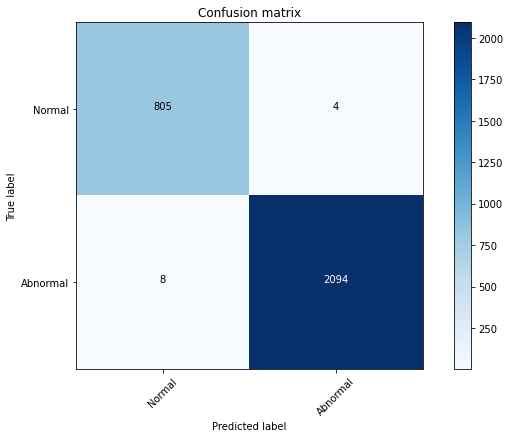

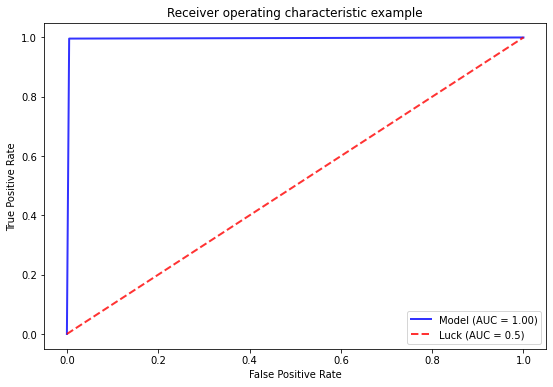

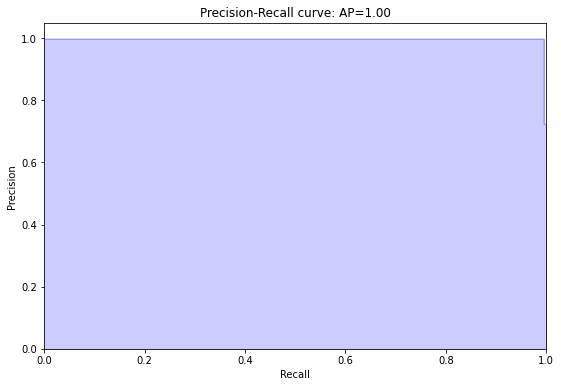

In [14]:
plot_model_results(model, history, model_path,
                   data, model_name, X_test, Y_test)

In [15]:
model_path = os.path.join(model_path_parent, model_name+"_"+data)
model.save(model_path)

INFO:tensorflow:Assets written to: C:\Users\guthr\ML4HC\01-ECG_Classification\Submission\01-ECG_Classification\03-Models/01-Ptbdb/04-Task4\TFCNNAUG_ptbdb\assets
